In [23]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field1', 'Field2', 'Field3', 'Field5', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'Field13', 'FieldA', 'FieldB', 'FieldC', 'FieldD', 'FieldE', 'FieldF', 'FieldG', 'FieldH', 'FieldI', 'FieldK', 'FieldL', 'FieldM', 'FieldO', 'FieldP', 'FieldQ', 'FieldR', 'FieldS', 'FieldT', 'FieldU', 'FieldV', 'FieldW', 'FieldX', 'FieldY', 'H_North', 'H_South', 'ArchE', 'ArchNE', 'ArchNW', 'ArchSE', 'ArchW']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [45]:
#import configuration for selected file
from config import FieldX as field
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [46]:
#import all required packages
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import subprocess

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord,Angle 
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord,skycoord_to_pixel
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry, CircularAperture
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

from regions import read_ds9, write_ds9, CircleSkyRegion

In [47]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

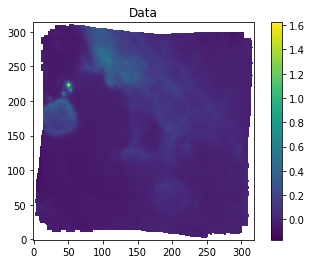

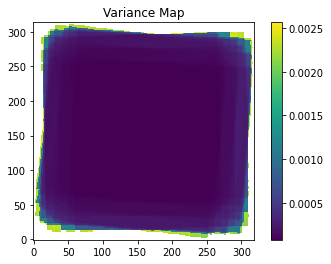

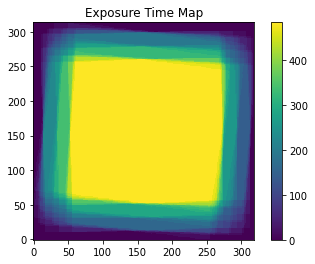

In [48]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

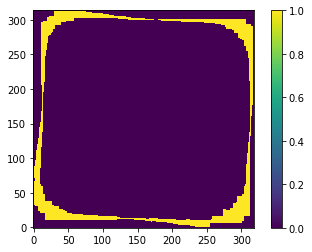

In [49]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<field.m1cut,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed
#the above can be adjusted if there are obvious sources near the edges of the map

#plot any of the mask to verify
plt.figure()
plt.imshow(mask,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [50]:
#create background model for image using median method
bkg_estimator = MedianBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox, bkgbox), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = segdetsig*bkg_rms

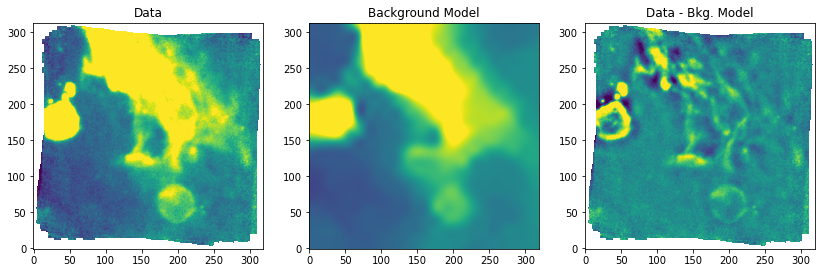

In [51]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))
ax1.set_title('Data')

#set the image limits for the plots
minval=-0.1
maxval=0.1

ax1.imshow(data,origin='lower',vmin=minval,vmax=maxval)
ax2.set_title('Background Model')
ax2.imshow(bkg,origin='lower',vmin=minval,vmax=maxval)
ax3.set_title('Data - Bkg. Model')
ax3.imshow(data_bkgsub,origin='lower',vmin=minval,vmax=maxval)
plt.show()

In [52]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

#removed labels that exist in masked region
if field.m2lims is not None:
    mask2=np.zeros(np.shape(mask))
    for lim in field.m2lims:
        mask2[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm.remove_masked_labels(mask2.astype('bool'))


In [53]:
#lets take a look at deblending sources
if segm is not None:
    segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)
else:
    segm_deblend=segm #if segm is empty pass it on to avoid errors

#remove any sources that should be masked (mask3) 
if field.m3lims is not None:
    mask3=np.zeros(np.shape(mask))
    for lim in field.m3lims:
        mask3[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm_deblend.remove_masked_labels(mask3.astype('bool'))

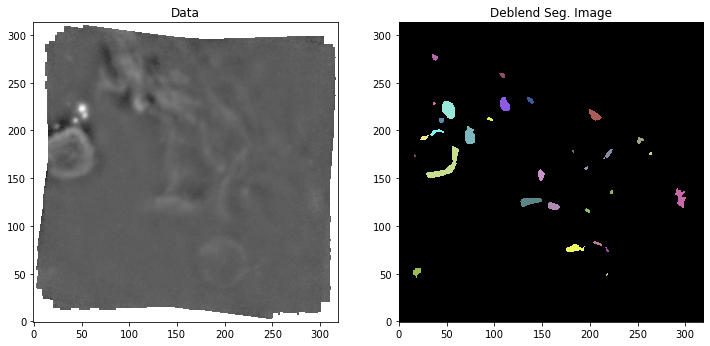

In [54]:
#make plot of segmentation image to show detected sources side by side with data
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
if segm is not None:
    cmap = segm.make_cmap(seed=123)
    ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Deblend Seg. Image')
plt.show()

In [55]:
#now lets look at building a catalog from the deblended segmentation map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [56]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#change format of columns to save fewer decimal places
for col in tbl2.colnames:
    if col!='sky_centroid': #skip sky centroid since its problematic in this context
        tbl2[col].info.format = '%.4G'
    
#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,18.51,51.91,"266.56749096286615,-28.861205956048867",-0.04116,-0.04479,-2.463,55,2.649,1.684,55.42,0.2848,-0.1962,0.2101,0.7719,0.3642,1.573,5.227,11.74,0.7572,3.296,2.268,0.1349,-0.04423,-0.04422,0.001666,6.174
2,217.3,48.86,"266.51907746881864,-28.86186057650226",0.02211,0.0306,0.153,5,0.9911,0.3469,45.32,4.705,-7.292,4.623,0.9368,0.65,2.857,1.749,2.667,0.1132,3.951,0.2254,0.02496,0.03115,0.03121,0.001687,0.5298
3,216.9,75.65,"266.51916887065033,-28.856143928961338",-0.01015,0.02307,0.3691,16,1.954,0.669,-58.14,1.685,1.769,0.8113,0.9396,0.6577,2.921,3.439,4.01,0.1618,3.522,0.6376,0.03631,0.02311,0.02311,0.00447,1.001
4,207.1,82.09,"266.52155465162025,-28.854770503271606",-0.01893,0.03953,0.8696,22,2.577,0.6943,-20.14,0.3787,1.244,1.846,0.963,0.7305,3.711,4.443,7.601,0.1959,3.649,0.8537,0.04249,0.03979,0.04032,0.00627,0.8855
5,197.1,115.9,"266.5239910648908,-28.847565374947578",-0.002548,0.05159,0.8255,16,1.511,0.8373,-33.64,0.7411,0.9119,1.123,0.8325,0.446,1.805,2.877,6.868,0.167,3.737,0.708,0.03593,0.05188,0.05189,0.002159,0.7608
6,160.6,120.7,"266.5328752519608,-28.846535674814877",-0.02072,0.03618,2.858,79,3.117,1.904,-22.76,0.1288,0.1234,0.25,0.7918,0.3892,1.637,6.081,20.55,0.2846,2.977,6.081,0.07866,0.03713,0.03624,0.003706,3.546
7,222.1,135.3,"266.51790063795545,-28.843409339369728",0.1894,0.06001,0.6601,11,1.092,0.7596,74.73,1.671,-0.455,0.9003,0.7187,0.3046,1.438,2.215,3.452,0.1223,3.358,0.6738,0.02989,0.06015,0.06026,0.001107,0.8096
8,148.1,153.4,"266.5359355162544,-28.83955771857206",0.02181,0.0157,1.067,68,2.88,1.787,-87.08,0.3125,0.01956,0.1211,0.7841,0.3794,1.611,5.644,16.5,0.2769,3.134,3.985,0.07251,0.01637,0.01611,0.00253,3.687


In [57]:
#write out the resulting table to file
ascii.write(tbl2, field.name+'_'+str(wavelength)+'um_seg.dat', overwrite=True)

Now lets try another other source detection method for comparison

In [58]:
from photutils import DAOStarFinder,IRAFStarFinder

In [59]:
#lets produce a new background map that's more optimized for point sources to use with DAOfind...
bkg_estimator_ps = MMMBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data_ps = Background2D(data,(8, 8), filter_size=(3, 3),bkg_estimator=bkg_estimator_ps,edge_method='pad') #smaller box?, 20x20, 25x25?
bkgps_rms=bkg_data_ps.background_rms
bkgps=bkg_data_ps.background 

#create background subtracted image
data_bkgsub_ps = data - bkgps

In [60]:
#do statistics on image - daofind requires a single value for threshold rather than a 2d map
print('Seg. Map mean/median Threshold/3.0 for comparison: ', (np.mean(threshold)/3.,np.median(threshold)/3.))

mean, median, std = sigma_clipped_stats(data_bkgsub, sigma=3.0)  
print('Seg Map Bkgsub data mean, med, std for comparison: ',(mean, median, std))  

mean, median, std = sigma_clipped_stats(data_bkgsub_ps, sigma=3.0)  
print('DAOFind Data mean, med, std: ',(mean, median, std))  

Seg. Map mean/median Threshold/3.0 for comparison:  (0.01538190571913258, 0.011562219883996505)
Seg Map Bkgsub data mean, med, std for comparison:  (-0.0019931554203230545, -0.0024359937228208006, 0.017016404126051186)
DAOFind Data mean, med, std:  (-0.00047554261309231885, -0.0009010421345902952, 0.012510696883884334)


In [61]:
#Before star finding lets mask areas in the image that were also masked in the seg. map

#make high cut on edges of fields for DAOphot - note that this is quite a bit larger than the seg map
mask4=np.where(tmapnorm<0.75,tmapnorm,0).astype('bool')

#create a single mask from the combination of the earlier masks
if field.m3lims is not None:
    maskcombine=(mask4 == 1) | (mask2 == 1) | (mask3 == 1)
elif field.m2lims is not None:
    maskcombine=(mask4 == 1) | (mask2 == 1)
else:
    maskcombine=(mask4 == 1)

#create masked array for the background subtracted data
data_bkgsub_ma = np.ma.masked_array(data_bkgsub_ps, mask=maskcombine)

#plot the masked data
#plt.figure()
#plt.imshow(data_bkgsub_ma)
#plt.colorbar()
#plt.show()

In [62]:
#now run starfinder to find sources 
daofind = DAOStarFinder(fwhm=4.2, threshold=finddetsig*std)
DAOsources = daofind(data_bkgsub_ma,mask=maskcombine)

StarFinder = IRAFStarFinder(fwhm=4.2, threshold=finddetsig*std)
IRAFsources = StarFinder(data_bkgsub_ma,mask=maskcombine)

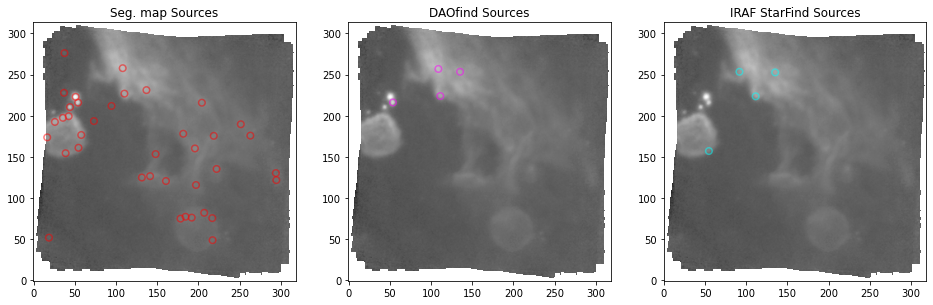

In [63]:
#plot data with apertures on detected sources
if DAOsources is not None:
    Dpositions = np.transpose((DAOsources['xcentroid'], DAOsources['ycentroid']))
    Dapertures = CircularAperture(Dpositions, r=4.)

if IRAFsources is not None:
    Ipositions = np.transpose((IRAFsources['xcentroid'], IRAFsources['ycentroid']))
    Iapertures = CircularAperture(Ipositions, r=4.)
    
if tbl2 is not None:
    Spositions = np.transpose((tbl2['xcentroid'], tbl2['ycentroid']))
    Sapertures = CircularAperture(Spositions, r=4.)

norm = ImageNormalize(stretch=SqrtStretch())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 10))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Seg. map Sources')
if tbl2 is not None:
    Sapertures.plot(color='red', lw=1.5, alpha=0.5,axes=ax1)

ax2.imshow(data, origin='lower', cmap='Greys_r',norm=norm)
ax2.set_title('DAOfind Sources')
if DAOsources is not None:
    Dapertures.plot(color='magenta', lw=1.5, alpha=0.5,axes=ax2)

ax3.imshow(data, origin='lower', cmap='Greys_r',norm=norm)
ax3.set_title('IRAF StarFind Sources')
if IRAFsources is not None:
    Iapertures.plot(color='cyan', lw=1.5, alpha=0.5,axes=ax3)

plt.show()

In [64]:
#lets add ra, dec coordinates of sources to DAOsources table
if DAOsources is None:
    Nsources=0
else:
    Nsources=len(DAOsources['id'])

scs=[]

for i in range(0,Nsources):
    xcoord=DAOsources['xcentroid'][i]
    ycoord=DAOsources['ycentroid'][i]
    sc=pixel_to_skycoord(xcoord,ycoord,wcsmap)
    scs.append(sc)

if DAOsources is not None:
    DAOsources['sky_centroid']=scs

    #change format of columns to save fewer decimal places
    for col in DAOsources.colnames:
        if col!='sky_centroid': #skip sky centroid since its problematic in this context
            DAOsources[col].info.format = '%.4G'

#pring DAO sources table?
#DAOsources

In [65]:
#write out the resulting table to file
ascii.write(DAOsources, field.name+'_'+str(wavelength)+'um_dao.dat', overwrite=True)

In [66]:
#create ds9 regions file for segmentation map sources
#start by getting lists of coords from table
sourcecoords=tbl2['sky_centroid']

#set size of regions 
radius = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"

#loop through and create region instances for each source
regions=[]
for i in range(0,len(sourcecoords)):
    region = CircleSkyRegion(sourcecoords[i], radius)
    regions.append(region)
    
#write out region file
write_ds9(regions, field.name+'_seg.reg')


In [67]:
#change the color of the regions to red - no built in way to do this in regions package :-/
with open(field.name+'_seg.reg', 'r+') as f:
    text = f.read()
    text = re.sub(r'\)', r') # color=red', text)
    f.seek(0)
    f.write(text)
    f.truncate()

In [68]:
#create ds9 region file for DAO sources

sourcecoords=DAOsources['sky_centroid']

regions=[]
for i in range(0,len(sourcecoords)):
    region = CircleSkyRegion(sourcecoords[i], radius)
    regions.append(region)
    
#write out region file
write_ds9(regions, field.name+'_DF.reg')

In [69]:
#change the color of the regions to cyan - no built in way to do this in regions package :-/
with open(field.name+'_DF.reg', 'r+') as f:
    text2 = f.read()
    text2 = re.sub(r'\)', r') # color=cyan', text2)
    f.seek(0)
    f.write(text2)
    f.truncate()

In [70]:
#create new region file including both sets of sources
newregtext=text+text2[45:]

with open(field.name+'.reg', 'w+') as f:
    f.seek(0)
    f.write(newregtext)
    f.truncate()

In [71]:
#open ds9 and load in the region file that was just saved
if ds9path is not None:
    subprocess.Popen(ds9path+' '+field.filename+ ' -mode region -regions load '+field.name+'.reg',shell=True) 

In [72]:
#user defined regions can be passed to the code using ds9. Simply add new regions to the prompt and then save the new
#regions file as field.name+'_ds9.reg'. This will be loaded in the photometry script if present. 

In [ ]:
#this can be used to read the regions file back in after modification
#load in sources from region file. Option to use original regions or a new regions file
#regfile=field+'.reg'
#regfile=fieldconfig.field+'_ds9.reg'

#new_regions = read_ds9(regfile)

In [ ]:
#new_regions